<!--BOOK_INFORMATION-->
<a href="https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv" target="_blank"><img align="left" src="data/cover.jpg" style="width: 76px; height: 100px; background: white; padding: 1px; border: 1px solid black; margin-right:10px;"></a>
*This notebook contains an excerpt from the book [Machine Learning for OpenCV](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv) by Michael Beyeler.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/mbeyeler/opencv-machine-learning).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv)!*

<!--NAVIGATION-->
< [Getting Acquainted with Deep Learning](09.03-Getting-Acquainted-with-Deep-Learning.ipynb) | [Contents](../README.md) | [Training a Deep Neural Net to Classify Handwritten Digits Using Keras](09.05-Training-a-Deep-Neural-Net-to-Classify-Handwritten-Digits-Using-Keras.ipynb) >

https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

# Training an MLP in OpenCV to Classify Handwritten Digits

In this section, we will use an MLP in OpenCV to classify
handwritten digits from the popular MNIST dataset, which has been constructed by Yann
LeCun and colleagues and serves as a popular benchmark dataset for machine learning
algorithms.

## Loading the MNIST dataset

The easiest way to obtain the MNIST dataset is using Keras:

In [1]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


This will download the data from the Amazon Cloud (might take a while depending on
your internet connection) and automatically split the data into training and test sets.

This data comes in a format that we are already familiar with:

In [2]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

We should take note that the labels come as integer values between zero and nine
(corresponding to the digits 0-9):

In [3]:
import numpy as np
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

We can have a look at some example digits:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

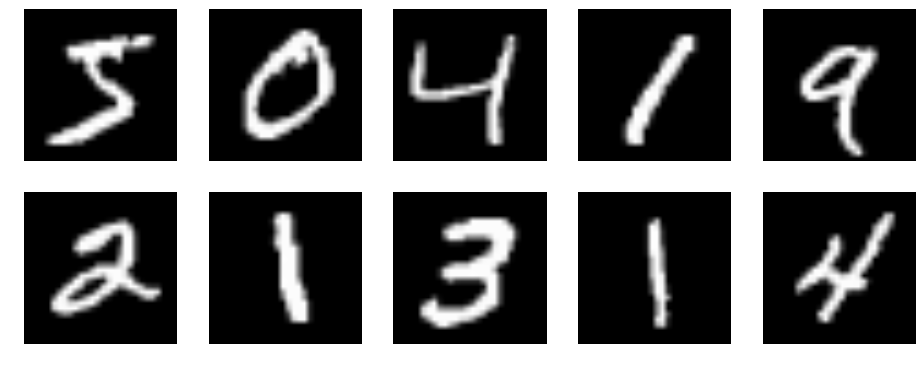

In [5]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i, :, :], cmap='gray')
    plt.axis('off')
plt.savefig('mnist-examples.png')

In fact, the MNIST dataset is the successor to the NIST digits dataset provided by scikit-learn
that we used before (`sklearn.datasets.load_digits` (refer to [Chapter 2](02.00-Working-with-Data-in-OpenCV.ipynb), *Working
with Data in OpenCV and Python*).

Some notable differences are as follows:
- MNIST images are significantly larger (28x28 pixels) than NIST images (8x8 pixels), thus paying more attention to fine details, such as distortions and individual differences between images of the same digit
- The MNIST dataset is much larger than the NIST dataset, providing 60,000 training and 10,000 test samples (as compared to a total of 5,620 NIST images)

## Preprocessing the MNIST dataset

As we learned in [Chapter 4](04.00-Representing-Data-and-Engineering-Features.ipynb), *Representing Data and Engineering Features*, there are a number
of preprocessing steps we might like to apply here, such as **centering**, **scaling**, and **representing categorical features**.

The easiest way to transform `y_train` and `y_test` is by the one-hot encoder from scikit-learn:

In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, dtype=np.float32)
y_train_pre = enc.fit_transform(y_train.reshape(-1, 1))

This will transform the labels of the training set from a `<n_samples x 1>` vector with
integers 0-9 into a `<n_samples x 10>` matrix with floating point numbers 0.0 or 1.0.

Analogously, we can transform `y_test` using the same procedure:

In [7]:
y_test_pre = enc.fit_transform(y_test.reshape(-1, 1))

In addition, we need to preprocess `X_train` and `X_test` for the purpose of working with
OpenCV. Currently, `X_train` and `X_test` are 3-D matrices `<n_samples x 28 x 28>`
with integer values between 0 and 255. Preferably, we want a 2-D matrix `<n_samples x
n_features>` with floating point numbers, where `n_features` is 784:

In [8]:
X_train_pre = X_train.astype(np.float32) / 255.0
X_train_pre = X_train_pre.reshape((X_train.shape[0], -1))
X_test_pre = X_test.astype(np.float32) / 255.0
X_test_pre = X_test_pre.reshape((X_test.shape[0], -1))

Then we are ready to train the network.

## Training an MLP using OpenCV

We can set up and train an MLP in OpenCV with the following recipe:

Instantiate a new MLP object:

In [9]:
import cv2
mlp = cv2.ml.ANN_MLP_create()

Specify the size of every layer in the network. We are free to add as many layers as we want, but we need to make sure that the first layer has the same number of neurons as input features (784 in our case), and that the last layer has the same number of neurons as class labels (10 in our case):

In [10]:
mlp.setLayerSizes(np.array([784, 512, 512, 10]))

Specify an activation function. Here we use the sigmoidal activation function
from before:

In [11]:
mlp.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM, 2.5, 1.0)

Specify the training method. Here we use the backpropagation algorithm
described above. We also need to make sure that we choose a small enough
learning rate. Since we have on the order of $10^5$ training samples, it is a good idea
to set the learning rate to at most $10^{-5}$:

In [12]:
mlp.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)
mlp.setBackpropWeightScale(0.0001)

Specify the termination criteria. Here we use the same criteria as above: to run
training for ten iterations (`term_max_iter`) or until the error does no longer
decrease significantly (`term_eps`):

In [13]:
term_mode = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS
term_max_iter = 10
term_eps = 0.01
mlp.setTermCriteria((term_mode, term_max_iter, term_eps))

Train the network on the training set (`X_train_pre`):

When the training completes, we can calculate the accuracy score on the training set to see
how far we got:

In [14]:
mlp.train(X_train_pre, cv2.ml.ROW_SAMPLE, y_train_pre)

True

In [15]:
_, y_hat_train = mlp.predict(X_train_pre)

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_hat_train.round(), y_train_pre)

0.92976666666666663

But, of course, what really counts is the accuracy score we get on the held-out test data:

In [17]:
_, y_hat_test = mlp.predict(X_test_pre)
accuracy_score(y_hat_test.round(), y_test_pre)

0.91690000000000005

91.7% accuracy is not bad at all if you ask me! The first thing you should try is to change the
layer sizes in `In [10]` above, and see how the test score changes.
As you add more neurons
to the network, you should see the training score increase—and with it, hopefully, the test
score.

However, having `N` neurons in a single layer is not the same as having them spread
out over several layers! Can you confirm this observation?

<!--NAVIGATION-->
< [Getting Acquainted with Deep Learning](09.03-Getting-Acquainted-with-Deep-Learning.ipynb) | [Contents](../README.md) | [Training a Deep Neural Net to Classify Handwritten Digits Using Keras](09.05-Training-a-Deep-Neural-Net-to-Classify-Handwritten-Digits-Using-Keras.ipynb) >